# Прогнозирование оттока клиентов

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Описание услуг

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

# Цель работы

Построить модель, которая предскажет уход клиента от оператора связи «Ниединогоразрыва.ком». Что бы вовремя предложить нелояльным клиентам скидку и этим минимизировать финансовые потери оператора.

# План работы

1. Анализ
    1. Импорт библиотек
    2. Изучение датафрейма contract
    3. Изучение датафрейма personal
    4. Изучение датафрейма internet
    5. Изучение датафрейма phone
    6. Выводы
2. Предобработка данных
    1. Создание таргета на основе столбцов BeginDate и EndDate
    2. Замена типа данных в столбцах BeginDate и EndDate в датафрейме contract
    3. Замена типа данных и заполнение пропусков в столбце TotalCharges
    4. Объединение датафреймов и заполнение пропусков
    5. Замена регистра в столбцах customerID и gender
    6. Изучение графиков с корреляцией признаков
    7. Выводы
3. Моделирование
    1. Разделение датафрейма на тренировочную и тестовую выборки
    2. Кодирование признаков
    3. Построение моделей и подбор гиперпараметров
    4. Проверка модели на тестовой выборке
    5. Выводы
4. Отчет

## Анализ

### Импорт библиотек

In [ ]:
!pip install -q phik

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 11.1 MB/s eta 0:00:00


In [ ]:
pip install tabulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.5 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns
import warnings

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             roc_curve,
                             roc_auc_score)
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     cross_val_score,
                                     cross_val_predict)
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder)
from tabulate import tabulate

warnings.filterwarnings('ignore')

RANDOM_STATE = 80523

In [ ]:
contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

### Изучение датафрейма contract

In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
contract.sample(20)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5334,6386-SZZKH,2015-11-01,2020-01-01,Two year,Yes,Bank transfer (automatic),107.95,5397.5
5491,3703-TTEPD,2018-05-01,No,Month-to-month,No,Bank transfer (automatic),65.35,1482.14
1601,2927-QRRQV,2016-04-01,No,One year,Yes,Electronic check,94.65,4615.13
22,1066-JKSGK,2019-11-01,No,Month-to-month,No,Mailed check,20.15,61.05
3247,8853-TZDGH,2014-02-01,No,Two year,Yes,Bank transfer (automatic),111.60,8035.2
2334,9121-PHQSR,2018-10-01,No,Month-to-month,Yes,Credit card (automatic),85.05,1374.41
6325,4558-FANTW,2018-07-01,No,Month-to-month,No,Electronic check,91.85,1745.15
5464,3458-IDMFK,2018-01-01,No,Two year,Yes,Mailed check,20.75,518.75
1172,1641-RQDAY,2017-06-01,No,Month-to-month,Yes,Electronic check,100.40,3405.57
4981,8008-HAWED,2018-10-01,No,Month-to-month,Yes,Electronic check,50.75,812.0


Данным методом перебрала все столбцы. Подозрительная пустота только в  колонке 'TotalCharges', поэтому ее и оставила в анализе

In [ ]:
contract['TotalCharges'].value_counts()

           11
20.45       6
101.0       5
21.53       4
40.1        4
           ..
4357.5      1
3509.55     1
2530.8      1
2599.1      1
7251.82     1
Name: TotalCharges, Length: 6658, dtype: int64

In [ ]:
contract[contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Пропуски только у "новичков", это объяснимо тем, что история их суммарных трат еще не отображается

In [ ]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [ ]:
contract.duplicated().sum()

0

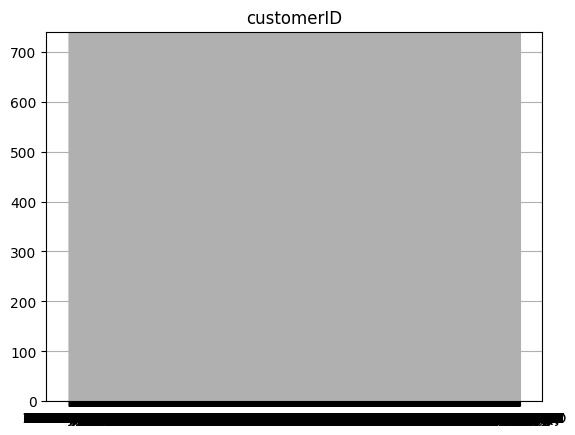

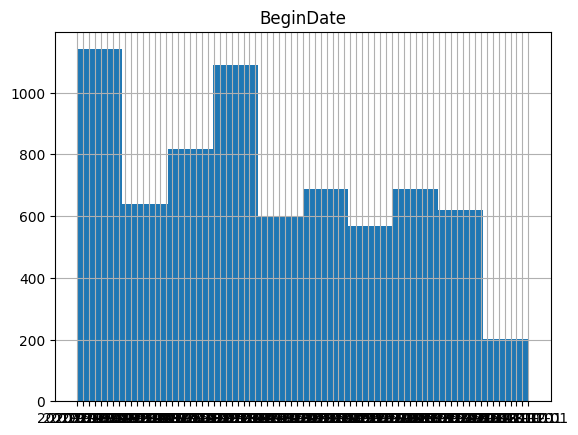

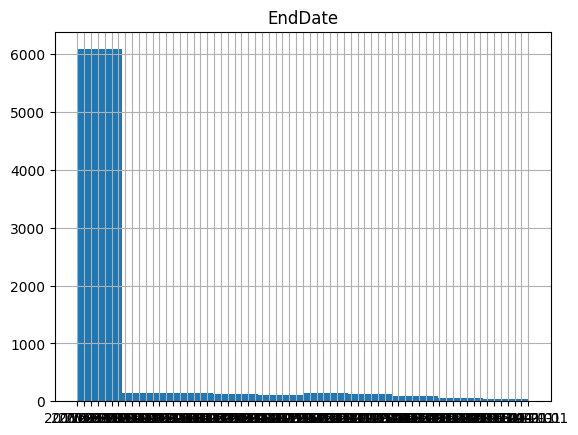

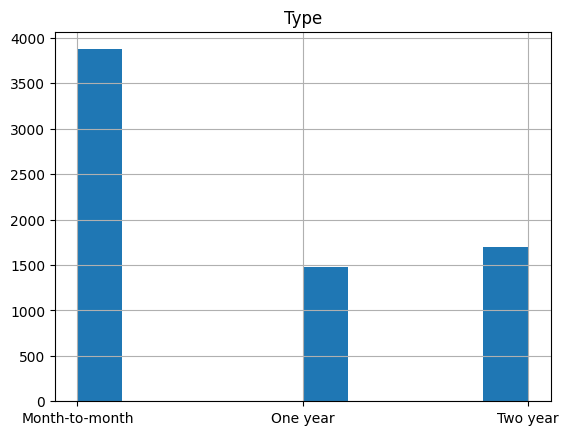

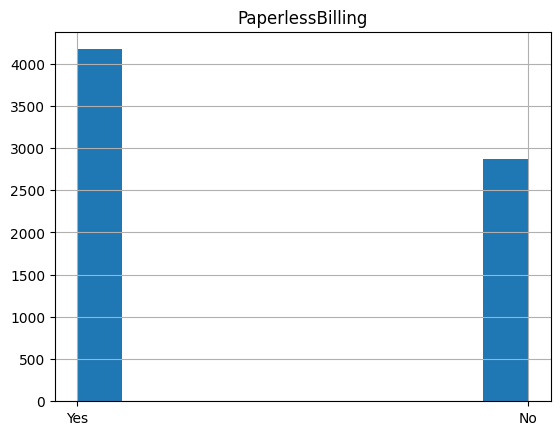

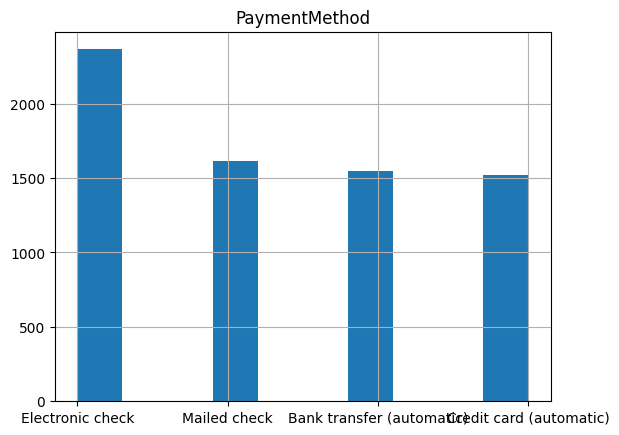

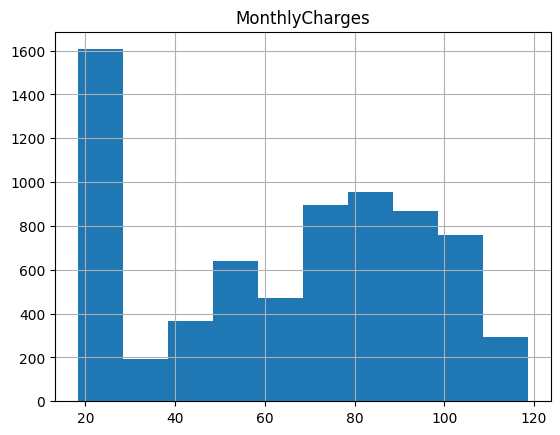

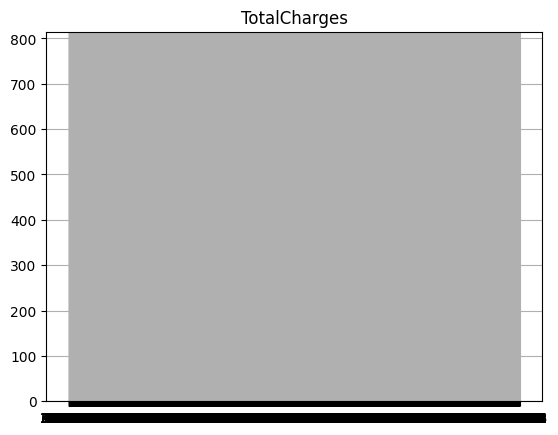

In [ ]:
for i in contract:
    contract[i].hist()
    plt.title(i)
    plt.show()

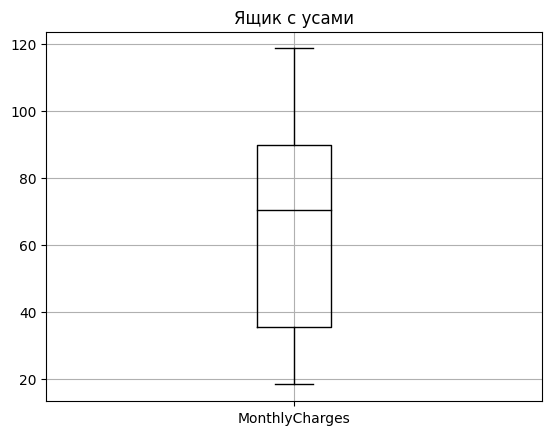

In [ ]:
contract.boxplot(column=['MonthlyCharges'], color='black')
plt.title('Ящик с усами')
plt.show()

В таблице с информацией о договоре 8 колонок и 7043 строки. Столбцам BeginDate и EndDate надо будет заменить тип данных, для того что бы посчитать количество дней пользования. Столбец TotalCharges тоже имеет неверный формат, так же там присутствуют пропуски, которые надо заполнить. Пропуски в TotalCharges только у "новичков", это объяснимо тем, что история их суммарных трат еще не отображается. Из графиков видно, что чаще используется тип оплаты ежемесячный, большее количество людей предпочитают безналичный расчет, способ оплаты чаще электронный чек. В столбце с ежемесячными тратами видно неравномерное распределение, в районе 20 у.е. явный всплеск изначально похожий на выбросы, но при просмотре "ящика с усами" видно, что перекос данных не такой сильный, и я делаю выводы, что у этой группы людей действительно ежемесячные траты намного меньше, чем у других. Явных дубликатов в таблице не обнаружено.

### Изучение датафрейма personal

In [ ]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
personal.sample(20)

,customerID,gender,SeniorCitizen,Partner,Dependents
2858,9512-PHSMG,Female,0,Yes,No
896,8975-SKGRX,Male,0,Yes,No
6731,0164-XAIRP,Female,0,No,No
6449,7601-WFVZV,Male,0,No,No
1667,4403-BWPAY,Male,0,No,No
2295,2672-DZUOY,Male,0,No,No
4975,4822-LPTYJ,Male,0,Yes,No
2607,5539-TMZLF,Male,1,No,No
6637,1122-YJBCS,Male,0,Yes,No
3609,4488-KQFDT,Female,0,No,No


In [ ]:
personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
personal.duplicated().sum()

0

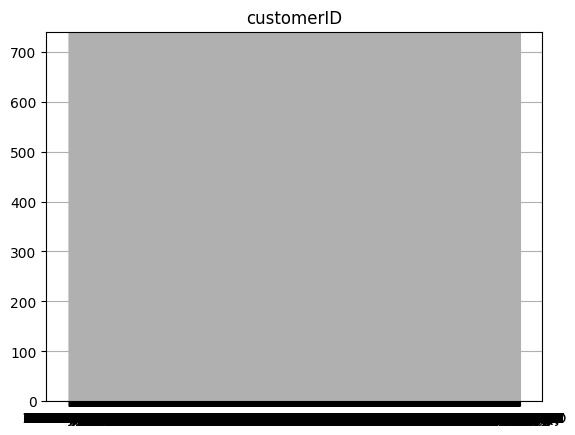

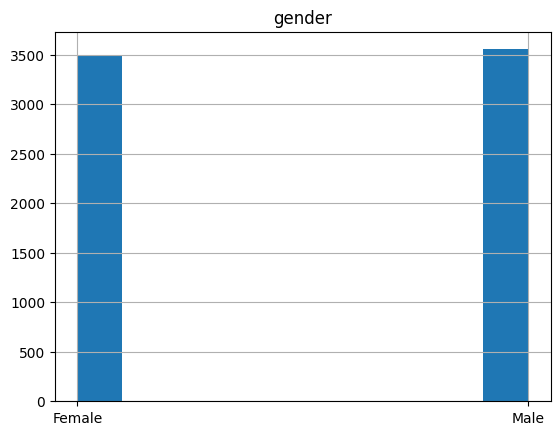

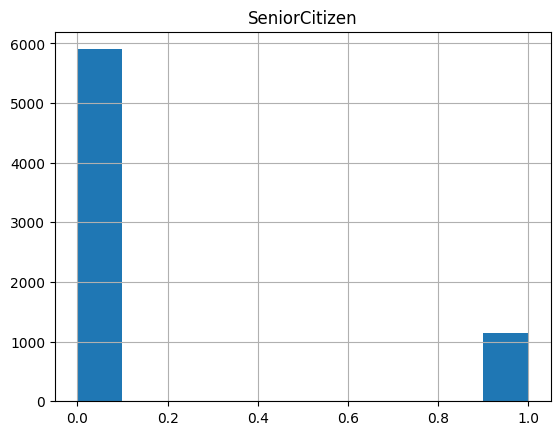

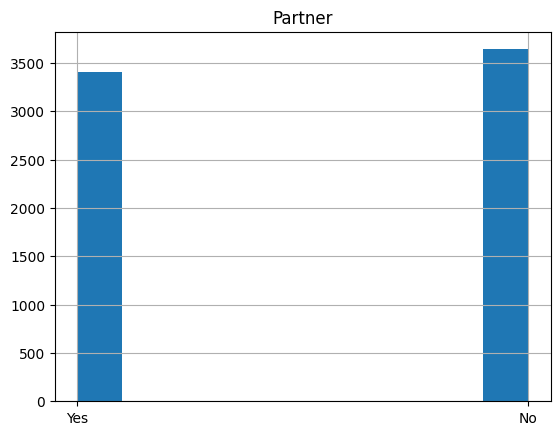

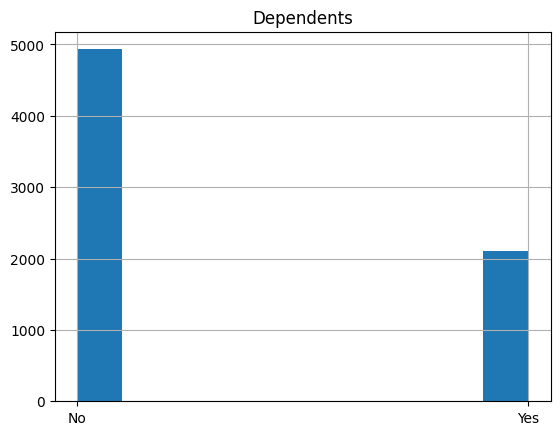

In [ ]:
for i in personal:
    personal[i].hist()
    plt.title(i)
    plt.show()

В таблице с персональными данными клиента 5 столбцов и 7043 строки. Из графиков видно, что мужчинт и женщин примерно одинаковое количество, большинство из пользоватей не пенсионеты, немного меньше людей которые находятся в браке, чем "свободных", клиенты чаще не имеют иждевенцев. Явных дубликатов и пропусков не обнаружено.

### Изучение датафрейма internet

In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [ ]:
internet.duplicated().sum()

0

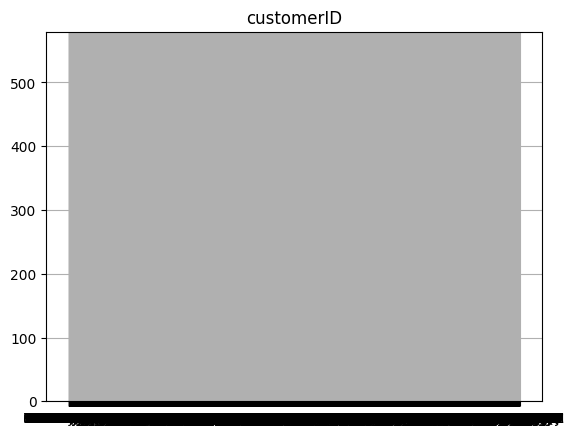

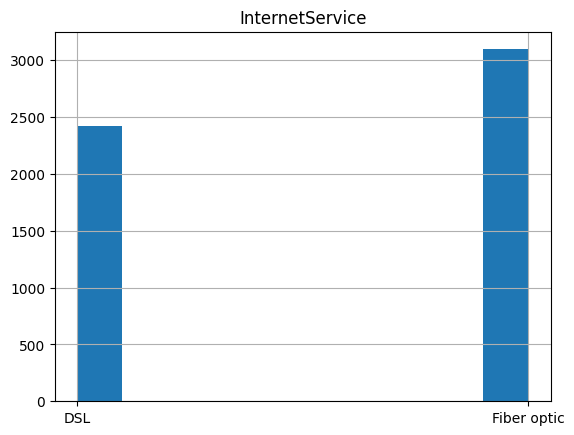

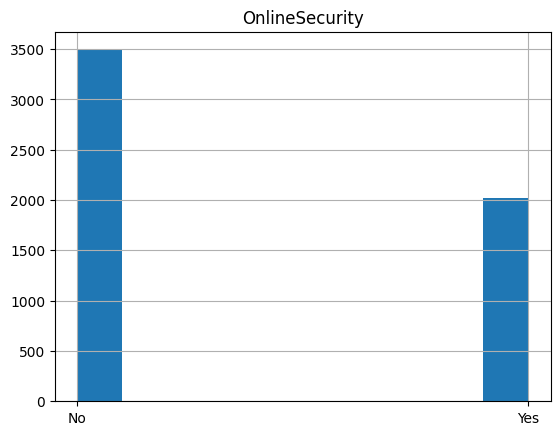

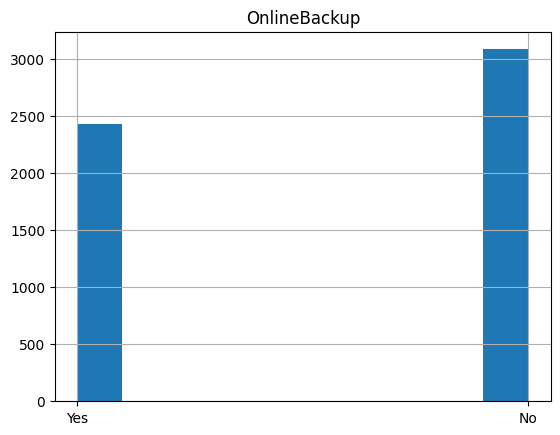

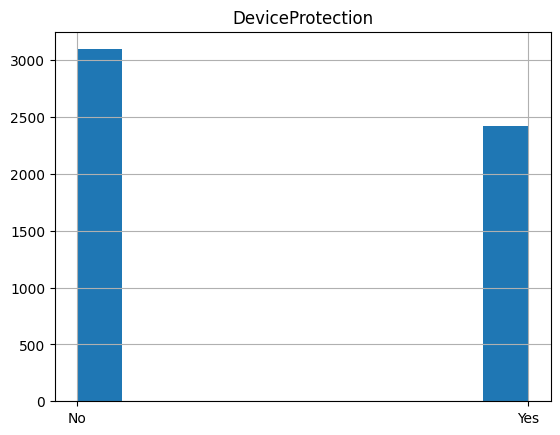

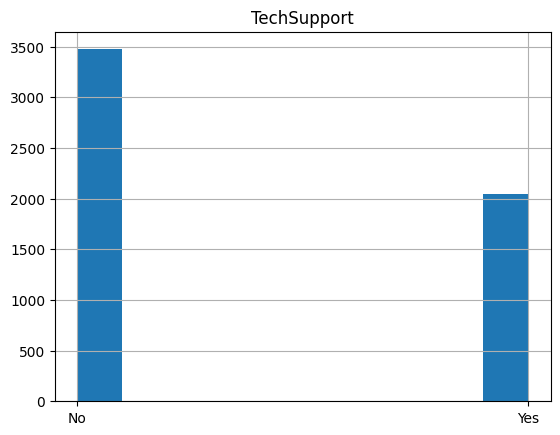

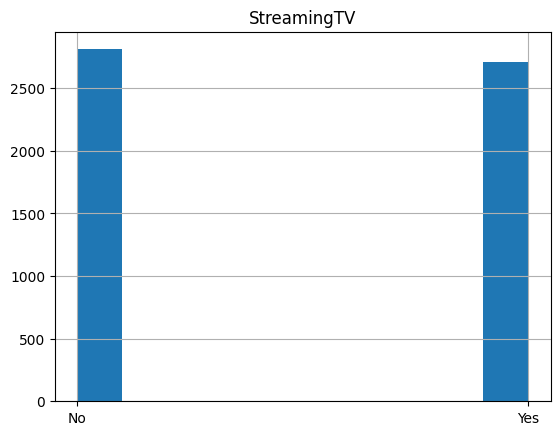

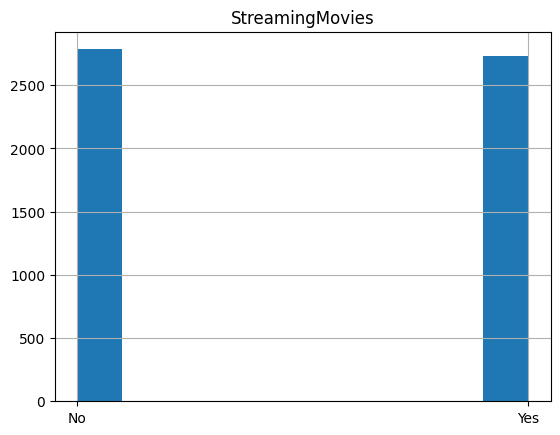

In [ ]:
for i in internet:
    internet[i].hist()
    plt.title(i)
    plt.show()

В таблице с интернет-услугами 8 столбцов и 5517 строк. Клиенты чаще выбирают оптоволокно, чаще не используют интернет-безопасность, чаще не пользуются онлайн-резервное копирование, чаще не используют защиту устройства, мало кто пользуется технической поддержкой, услуги потоковое тв и потоковые фильмы используют примерно одинаковое количество пользователей. Явных дубликатов и пропусков не обнаружено.

### Изучение датафрейма phone

In [ ]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [ ]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [ ]:
phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


In [ ]:
phone.duplicated().sum()

0

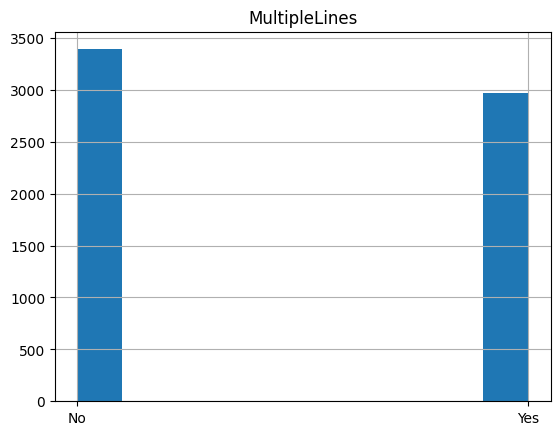

In [ ]:
phone['MultipleLines'].hist()
plt.title('MultipleLines')
plt.show()

В таблице с услугами телефонии 2 столбца и 6361 строка. Из графика видно, что клиенты чаще не пользуются возможностью ведения параллельных линий во время звонка. Явных дубликатов и пропусков не обнаружено

### Выводы

1. В таблице с информацией о договоре 8 колонок и 7043 строки. Столбцам BeginDate и EndDate надо будет заменить тип данных, для того что бы посчитать количество дней пользования. Столбец TotalCharges тоже имеет неверный формат, так же там присутствуют пропуски, которые надо заполнить. Пропуски в TotalCharges только у "новичков", это объяснимо тем, что история их суммарных трат еще не отображается. Из графиков видно, что чаще используется тип оплаты ежемесячный, большее количество людей предпочитают безналичный расчет, способ оплаты чаще электронный чек. В столбце с ежемесячными тратами видно неравномерное распределение, в районе 20 у.е. явный всплеск изначально похожий на выбросы, но при просмотре "ящика с усами" видно, что перекос данных не такой сильный, и я делаю выводы, что у этой группы людей действительно ежемесячные траты намного меньше, чем у других. Явных дубликатов в таблице не обнаружено.
2. В таблице с персональными данными клиента 5 столбцов и 7043 строки. Из графиков видно, что мужчит и женщин примерно одинаковое количество, большинство из пользоватей не пенсионеры, немного меньше людей которые находятся в браке, чем "свободных", клиенты чаще не имеют иждевенцев. Явных дубликатов и пропусков не обнаружено.
3. В таблице с интернет-услугами 8 столбцов и 5517 строк. Клиенты чаще выбирают оптоволокно, чаще не используют интернет-безопасность, чаще не пользуются онлайн-резервное копирование, чаще не используют защиту устройства, мало кто пользуется технической поддержкой, услуги потоковое тв и потоковые фильмы используют примерно одинаковое количество пользователей. Явных дубликатов и пропусков не обнаружено.
4. В таблице с услугами телефонии 2 столбца и 6361 строка. Из графика видно, что клиенты чаще не пользуются возможностью ведения параллельных линий во время звонка. Явных дубликатов и пропусков не обнаружено
5. Для дальнейшего исследования потребуется:
- заменить регистр в столбцах customerID и gender,
- заменить тип данных в некоторых столбцах в датафрейме contract,
- заполнить пропуски в столбце TotalCharges,
- объединить датафреймы и опять заполнить пропуски, так как датафреймы имеют разное количество строк, потому что клиенты пользуются не всеми услугами,
- создать новый столбец, таргет, на основе столбцов BeginDate и EndDate

Вопросов по данным не имею, всё понятно

## Предобработка данных

### Работа с датами

Добавляю целевой признак Target.Если EndDate = "No", то значит клиент не ушел и Target = 0.Если дата ухода есть, то Target = 1.

In [ ]:
contract['Target'] = (contract['EndDate'] != 'No').astype(int)
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0


Заменю пропуски в столбце EndDate, на дату выгрузки датасета

In [ ]:
contract['EndDate'] = np.where((contract.EndDate == 'No'), '2020-02-01', contract.EndDate)
contract['EndDate'].unique()

array(['2020-02-01', '2017-05-01', '2016-03-01', '2018-09-01',
       '2018-11-01', '2018-12-01', '2019-08-01', '2018-07-01',
       '2017-09-01', '2015-09-01', '2016-07-01', '2016-06-01',
       '2018-03-01', '2019-02-01', '2018-06-01', '2019-06-01',
       '2020-01-01', '2019-11-01', '2016-09-01', '2015-06-01',
       '2016-12-01', '2019-05-01', '2019-04-01', '2017-06-01',
       '2017-08-01', '2018-04-01', '2018-08-01', '2018-02-01',
       '2019-07-01', '2015-12-01', '2014-06-01', '2018-10-01',
       '2019-01-01', '2017-07-01', '2017-12-01', '2018-05-01',
       '2015-11-01', '2019-10-01', '2019-03-01', '2016-02-01',
       '2016-10-01', '2018-01-01', '2017-11-01', '2015-10-01',
       '2019-12-01', '2015-07-01', '2017-04-01', '2015-02-01',
       '2017-03-01', '2016-05-01', '2016-11-01', '2015-08-01',
       '2019-09-01', '2017-10-01', '2017-02-01', '2016-08-01',
       '2016-04-01', '2015-05-01', '2014-09-01', '2014-10-01',
       '2017-01-01', '2015-03-01', '2015-01-01', '2016-

Меняю тип данных в столбцах BeginDate и EndDate

In [ ]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['EndDate'] = pd.to_datetime(contract['EndDate'])
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   Target            7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 495.3+ KB


Нахожу сколько дней до выгрузки данных клиент пользовался услугами оператора, это будет новая фича для обучения

In [ ]:
contract["Amount_days"] = (contract["EndDate"] - contract["BeginDate"]).dt.days
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   Target            7043 non-null   int64         
 9   Amount_days       7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(5)
memory usage: 550.4+ KB


### Работа с ценами

Так пропуски в столбце у новых клиентов, то заменяю их на значения из столбца MonthlyCharges. Ведь не смотря на то, что это только первый день пользования у новых клиентов, сумма месячного платежа уже отображается, а значит итоговая сумма просто возможно не успела подгрузиться

Не сморя на пустые значения, меняю тип данных принудительно, заменяя пустые значения Nan

In [ ]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce', downcast=None)

Теперь заменяю пропущенные значения - Nan, на сумму месячного платежа

In [ ]:
contract.loc[contract['TotalCharges'].isna(), 'TotalCharges'] = contract['MonthlyCharges']

In [ ]:
contract['TotalCharges'].value_counts()

20.45      6
101.00     5
40.10      4
255.00     4
21.53      4
          ..
3509.55    1
2530.80    1
2599.10    1
693.96     1
7251.82    1
Name: TotalCharges, Length: 6664, dtype: int64

### Объединение таблиц

Объединяю все таблицы в один датасет

In [ ]:
data = contract \
    .merge(personal, on='customerID', how='left') \
    .merge(internet, on='customerID', how='left') \
    .merge(phone, on='customerID', how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Target            7043 non-null   int64         
 9   Amount_days       7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   5517 n

Поменяю регистр у столбцов customerID и gender

In [ ]:
data = data.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'})
data

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,Amount_days,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,...,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,2035.20,0,730,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7430.40,0,2191,...,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,325.60,0,337,...,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,2019-07-01,2020-02-01,Month-to-month,Yes,Mailed check,74.40,520.80,0,215,...,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


Из-за того, что не каждый клиент использует все предоставленные услуги оператора, при объединении таблиц возникли пропуски. Заполняю пропуски заглушкой 'No'

In [ ]:
data = data.fillna('No')
data.isna().sum()

CustomerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Target              0
Amount_days         0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

### Анализ ушедших пользователей

Рассмотрю распределение оттока клиентов оп годам

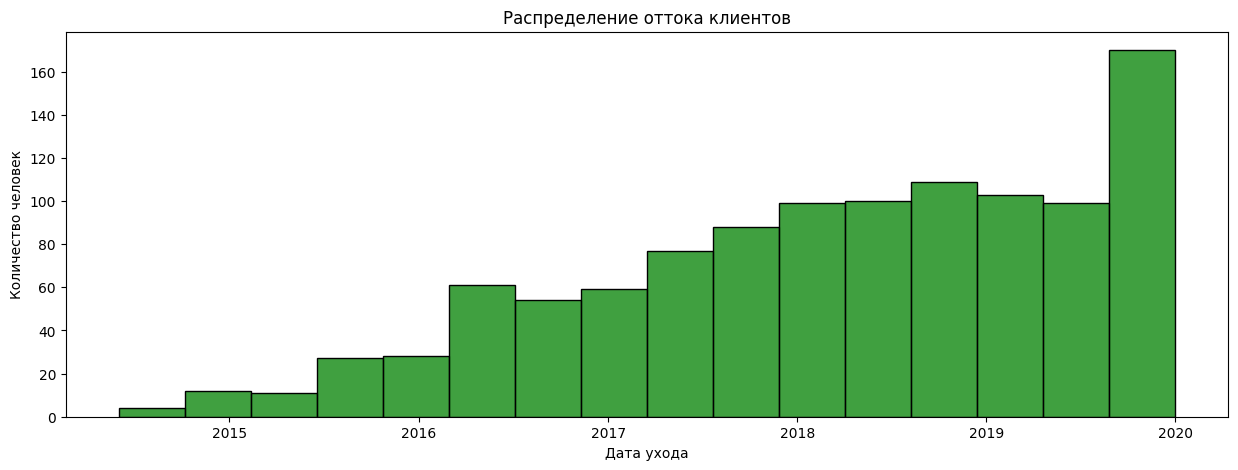

In [ ]:
plt.figure(figsize=(15, 5))
sns.histplot(data.query('EndDate !="2020-02-01"')['EndDate'], color='g')
plt.title('Распределение оттока клиентов')
plt.xlabel('Дата ухода')
plt.ylabel('Количество человек')
plt.show();

Судя по графику отток клиентов с конца 2017 года по конец 2019 был примерно на одном уровне, но ближе к дате выгрузки(2 февраля 2020) отток клиентов резко увеличился

Посмотрю как долго ушедшие клиенты пользовались услугами оператора

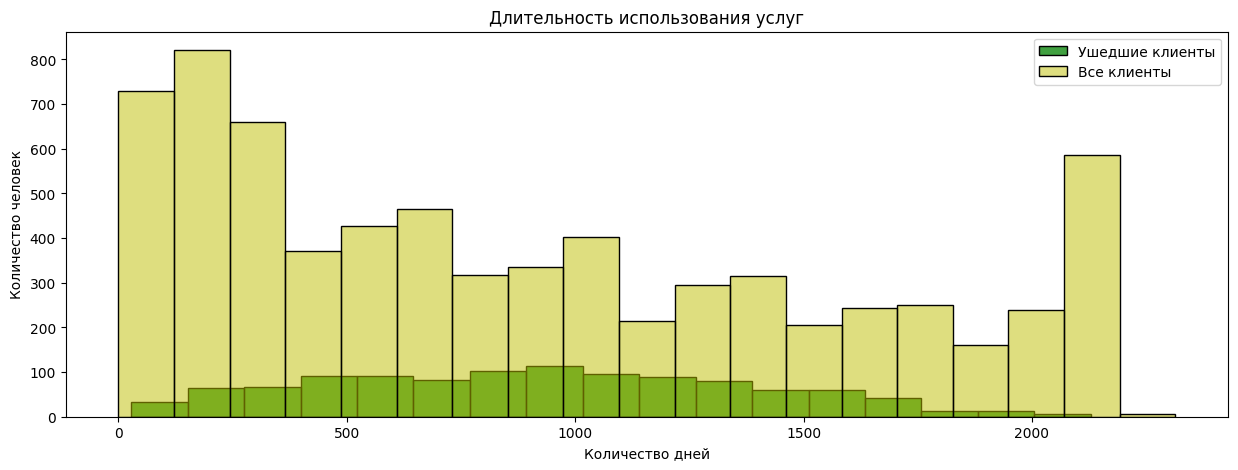

In [ ]:
plt.figure(figsize=(15, 5))
ax = sns.histplot(data.query('EndDate != "2020-02-01"')['Amount_days'], color='g', label='Ушедшие клиенты')
sns.histplot(data['Amount_days'], color='y', ax=ax, alpha=0.5, label='Все клиенты')
ax.legend()
plt.title('Длительность использования услуг')
plt.xlabel('Количество дней')
plt.ylabel('Количество человек')
plt.show();

Большинство ушедших клиентов пользовались услугами оператора около 3-х лет

Посмотрю на ежемесячные и суммарные траты ушедших клиентов

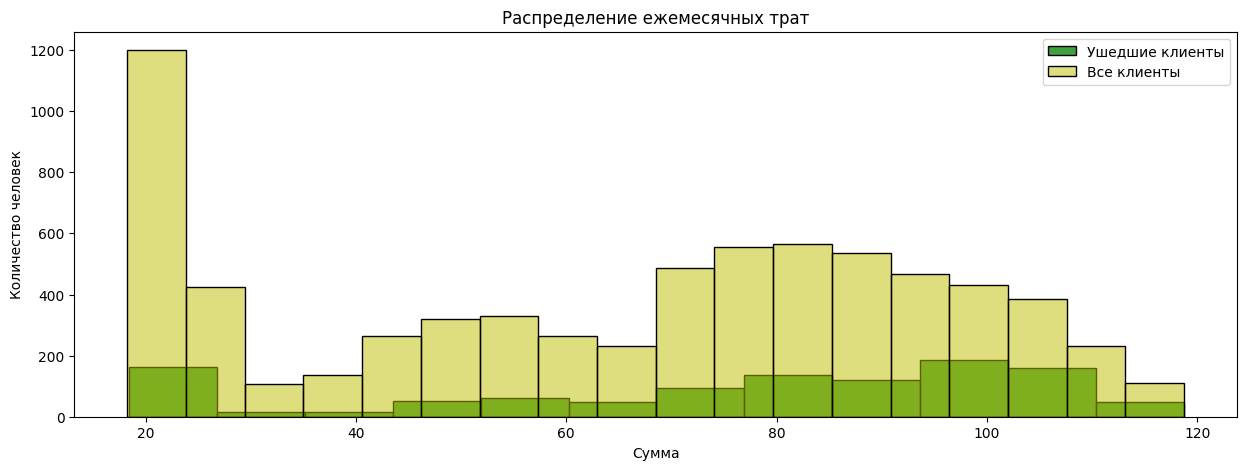

In [ ]:
#ежемесячные траты ушедших клиентов
plt.figure(figsize=(15, 5))
ax = sns.histplot(data.query('EndDate != "2020-02-01"')['MonthlyCharges'], color='g', label='Ушедшие клиенты')
sns.histplot(data['MonthlyCharges'], color='y', ax=ax, alpha=0.5, label='Все клиенты')
ax.legend()
plt.title('Распределение ежемесячных трат')
plt.xlabel('Сумма')
plt.ylabel('Количество человек')
plt.show();

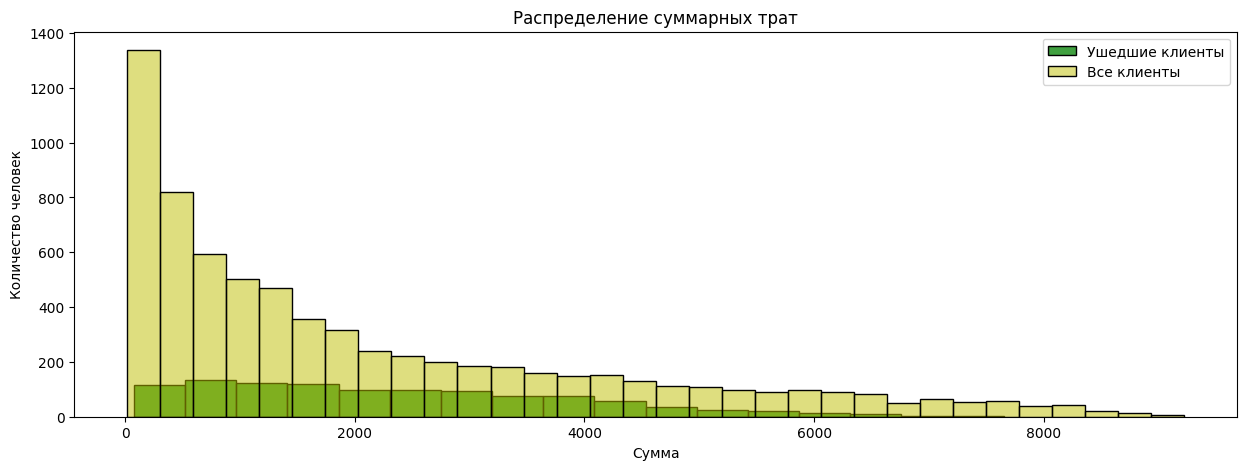

In [ ]:
#суммарные траты ушедших клиентов
plt.figure(figsize=(15, 5))
ax = sns.histplot(data.query('EndDate != "2020-02-01"')['TotalCharges'], color='g', label='Ушедшие клиенты')
sns.histplot(data['TotalCharges'], color='y', ax=ax, alpha=0.5, label='Все клиенты')
ax.legend()
plt.title('Распределение суммарных трат')
plt.xlabel('Сумма')
plt.ylabel('Количество человек')
plt.show();

Ушедшие клиенты тратили на услуги оператора больше

### Корреляция

Проверяю корреляцию целевого признак Target со всеми остальными признаками

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Target', 'Amount_days', 'SeniorCitizen']


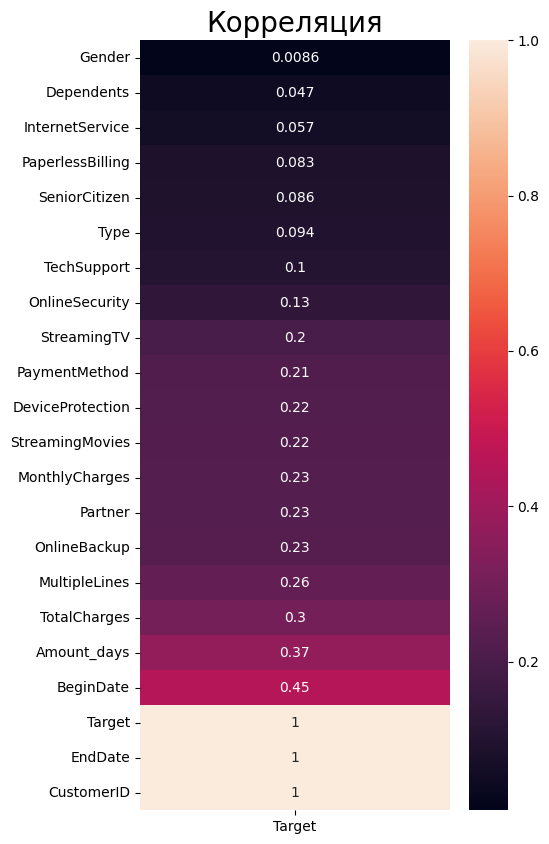

In [ ]:
correlation = data.phik_matrix()

plt.figure(figsize=(5,10))
sns.heatmap(correlation[['Target']].sort_values(by=['Target']), annot=True)
plt.title('Корреляция', fontsize=20)
plt.show();

Заметна сильная корреляция целевого признака с CustomerID  и EndDate. Что бы не было проблем при обучении модели нужно CustomerID перенести в индекс, а EndDate можно просто удалить

In [ ]:
data_matrix = data.drop(['SeniorCitizen'], axis=1)

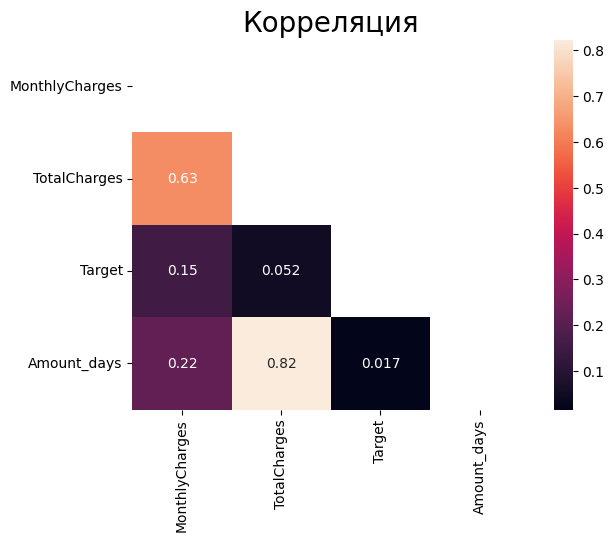

In [ ]:
matrix = np.triu(data_matrix.corr())
sns.heatmap(data_matrix.corr(), annot=True, mask=matrix)
plt.title('Корреляция', fontsize=20)
plt.show();

Заметна достаточно сильная корреляция Amount_days и TotalCharges, удаляю этот признак для предотвращения утечки при обучении

Переношу id пользователя в индекс

In [ ]:
data = data.set_index('CustomerID')

Удаляю признаки

In [ ]:
data = data.drop(['BeginDate', 'EndDate', 'TotalCharges', 'Gender',
                  'Dependents', 'InternetService', 'PaperlessBilling'], axis=1)
data.shape

(7043, 14)

### Вывод

- Пропуски в столбце EndDate заменены на дату выгрузки датасета
- Пропуски в столбце TotalCharges у новых клиентов,заменила их на значения из столбца MonthlyCharges. Ведь не смотря на то, что это только первый день пользования у новых клиентов, сумма месячного платежа уже отображается, а значит итоговая сумма просто возможно не успела подгрузиться
- Объеденила все таблицы в один датасет
- Заменен регистр у столбцов customerID и gender
- Из-за того, что не каждый клиент использует все предоставленные услуги оператора, при объединении таблиц возникли пропуски. Заполнила пропуски заглушкой 'No'
- Был рассмотрен оттока клиентов по годам.Судя по графику отток клиентов с конца 2017 года по конец 2019 был примерно на одном уровне, но ближе к дате выгрузки(2 февраля 2020) отток клиентов резко увеличился
- Большинство ушедших клиентов пользовались услугами оператора до 3-х лет
- Ушедшие клиенты тратили на услуги оператора больше
- Заметна сильная корреляция целевого признака с CustomerID и EndDate. Что бы не было проблем при обучении модели CustomerID был перенесен в индекс, а TotalCharges, EndDate и BeginDate удалены


## Моделирование

### Проверка баланса классов

In [ ]:
data['Target'].value_counts()

0    5942
1    1101
Name: Target, dtype: int64

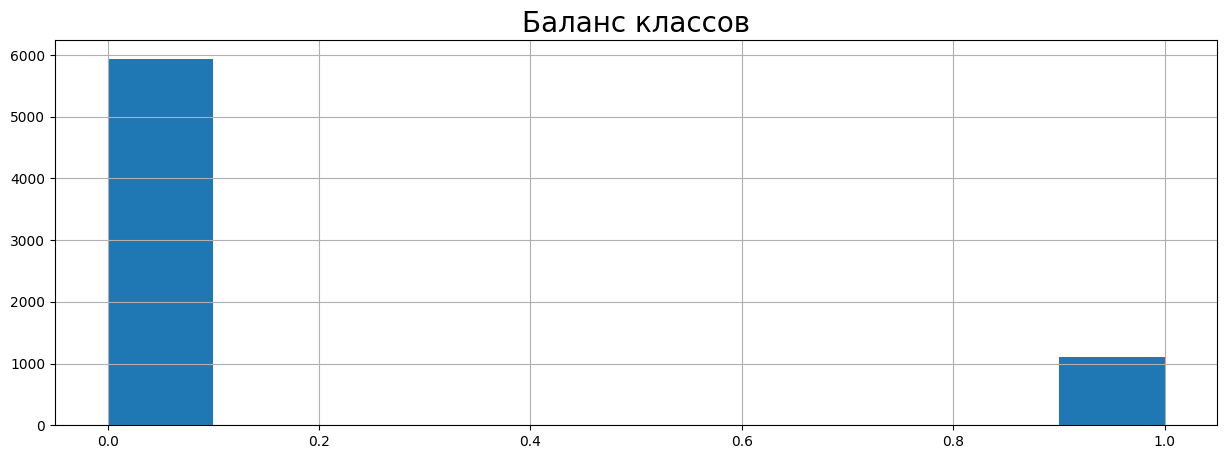

In [ ]:
data['Target'].hist(figsize=(15, 5))
plt.title('Баланс классов', fontsize=20)
plt.show();

Заметен сильный дисбаланс классов, но метрика ROC-AUC не чувствительная к дисбалансу, поэтому на это можно не обращать внимания.

### Разделение на тренировочную и тестовую выборки

In [ ]:
features = data.drop(['Target'], axis=1)
target = data['Target']

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify = target)

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(5282, 13)
(1761, 13)
(5282,)
(1761,)


### Кодирование

In [ ]:
features_ohe_train = features_train.copy()
features_ohe_test = features_test.copy()

In [ ]:
numerics = ['MonthlyCharges', 'Amount_days']

categories = ['Type', 'PaymentMethod', 'Partner',
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
               'StreamingTV', 'StreamingMovies', 'MultipleLines', 'SeniorCitizen']

Кодирую категориальные признаки тренировочной выборки

In [ ]:
onehot_encoder = OneHotEncoder(sparse=False, drop='first')

result_train = onehot_encoder.fit_transform(features_ohe_train[categories])
result_train = pd.DataFrame(result_train, columns=onehot_encoder.get_feature_names_out(categories),\
                                                                        index=features_ohe_train.index)
features_ohe_train = result_train.join(features_ohe_train[numerics])
features_ohe_train.head()

,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Partner_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,SeniorCitizen_1,MonthlyCharges,Amount_days
CustomerID,,,,,,,,,,,,,,,,
4123-FCVCB,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,75.85,365
5569-OUICF,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,101.30,883
0750-EBAIU,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,91.25,1522
2190-BCXEC,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,78.85,1218
2987-BJXIK,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,84.70,1583


Кодирую категориальные признаки тестовой выборки выборки

In [ ]:
result_test = onehot_encoder.transform(features_ohe_test[categories])
result_test = pd.DataFrame(result_test, columns=onehot_encoder.get_feature_names_out(categories),\
                                                                        index=features_ohe_test.index)
features_ohe_test = result_test.join(features_ohe_test[numerics])
features_ohe_test.head()

,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Partner_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,SeniorCitizen_1,MonthlyCharges,Amount_days
CustomerID,,,,,,,,,,,,,,,,
4694-PHWFW,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.95,245
8945-MUQUF,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,94.80,1492
2267-WTPYD,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,94.00,489
9526-BIHHD,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.70,123
0781-LKXBR,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,100.50,365


### Обучение моделей

In [ ]:
#функция для подсчета лучших метрик
def metrics(model):

    BEST_PARAMS = model.best_params_
    BEST_SCORE = model.best_score_
    #Accuracy = model.best_estimator_.score(features_ohe_train, target_train)
    acc = cross_val_score(model, features_ohe_train, target_train, scoring = 'accuracy').mean()

    print(f"ROC-AUC: {BEST_SCORE:.3f}, Accuracy:{acc:.3f}, BEST_PARAMETRS:{BEST_PARAMS}")

In [ ]:
#RandomForestClassifier - подбор лучших параметров
model_forest = RandomForestClassifier(random_state=RANDOM_STATE, class_weight = 'balanced')
parametrs_for = {'max_depth' : range(10, 100, 30),
                'n_estimators': range(300, 400, 500)}

model_for = GridSearchCV(model_forest, parametrs_for, cv=3, scoring='roc_auc', n_jobs = -1)
model_for.fit(features_ohe_train, target_train)

metrics(model_for)

ROC-AUC: 0.826, Accuracy:0.829, BEST_PARAMETRS:{'max_depth': 10, 'n_estimators': 300}


In [ ]:
#LGBMClassifier - подбор лучших параметров
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE, class_weight = 'balanced')
parametrs_lgbm= {'num_leaves':[30, 50, 100],
                'learning_rate':[.1, .3, .5],
                'n_estimators': [50, 100, 150]}

model_lg = GridSearchCV(model_lgbm, parametrs_lgbm, cv=3, scoring='roc_auc', n_jobs = -1)
model_lg.fit(features_ohe_train, target_train)

metrics(model_lg)

ROC-AUC: 0.880, Accuracy:0.884, BEST_PARAMETRS:{'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 30}


In [ ]:
#CatBoostClassifier - подбор лучших параметров
cat_m = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)
cat_param = {'depth': [3, 5, 7, 10],
            'learning_rate': [.1, .01, .5],
            'l2_leaf_reg': [1, 3, 5, 10],
            'iterations': [500]}

model_cat = GridSearchCV(cat_m, cat_param, cv=3, scoring='roc_auc', n_jobs = -1)
model_cat.fit(features_ohe_train, target_train)

metrics(model_cat)

ROC-AUC: 0.925, Accuracy:0.930, BEST_PARAMETRS:{'depth': 3, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.5}


### ROC-кривые

In [ ]:
probabilities_forest=cross_val_predict(model_for, features_ohe_train, target_train, cv=10)
fpr_forest,tpr_forest, _ =roc_curve(target_train,probabilities_forest)

probabilities_lgbm=cross_val_predict(model_lg, features_ohe_train, target_train, cv=10)
fpr_lgbm,tpr_lgbm, _ =roc_curve(target_train,probabilities_lgbm)

probabilities_cat=cross_val_predict(model_cat,features_ohe_train, target_train, cv=10)
fpr_cat,tpr_cat, _ =roc_curve(target_train,probabilities_cat)

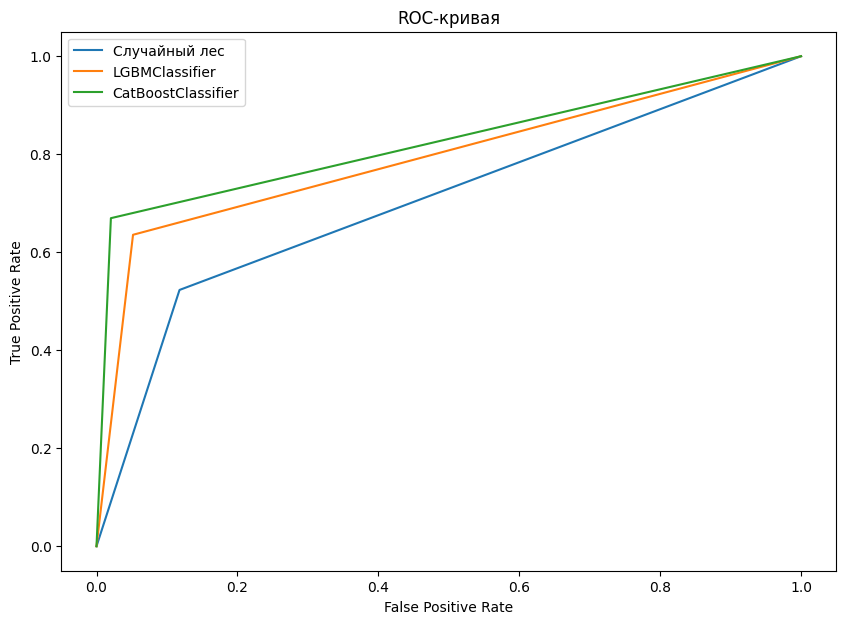

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(fpr_forest,tpr_forest,label='Случайный лес')
plt.plot(fpr_lgbm,tpr_lgbm,label='LGBMClassifier')
plt.plot(fpr_cat,tpr_cat,label='CatBoostClassifier')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show();

Кривые LGBMClassifier и CatBoostClassifier проходят значительно выше, значит качество модели выше

### Выбор лучшей модели и проверка на тестовых данных

In [ ]:
tabl = [["RandomForestClassifier", 0.826, 0.829],
        ["LGBMClassifier", 0.880, 0.884],
        ["CatBoostClassifier", 0.925, 0.930]]

col_names = ["Модель", "ROC-AUC", "Accuracy"]

print(tabulate(tabl, headers=col_names, tablefmt="fancy_grid"))

╒════════════════════════╤═══════════╤════════════╕
│ Модель                 │   ROC-AUC │   Accuracy │
╞════════════════════════╪═══════════╪════════════╡
│ RandomForestClassifier │     0.826 │      0.829 │
├────────────────────────┼───────────┼────────────┤
│ LGBMClassifier         │     0.88  │      0.884 │
├────────────────────────┼───────────┼────────────┤
│ CatBoostClassifier     │     0.925 │      0.93  │
╘════════════════════════╧═══════════╧════════════╛


Лучшая модель CatBoostClassifier, использую ее на тестовых данных

In [ ]:
#проверка лучшей модели на тестовой выборке
cat_predict = model_cat.predict_proba(features_ohe_test)[:, 1]
predict = model_cat.predict(features_ohe_test)
print ("ROC-AUC:", roc_auc_score(target_test, cat_predict))
print ("Accuracy:", accuracy_score(target_test, predict))

ROC-AUC: 0.9194286063868836
Accuracy: 0.9295854628052242


### Значимость признаков

In [ ]:
importances = pd.DataFrame(model_cat.best_estimator_.feature_importances_,
                           index = features_ohe_test.columns, columns=['importances'])
importances = importances.sort_values(by='importances', ascending=False)
importances


,importances
Amount_days,63.768671
MonthlyCharges,16.649937
Type_Two year,2.420995
Partner_Yes,2.244166
StreamingMovies_Yes,1.852825
MultipleLines_Yes,1.757190
DeviceProtection_Yes,1.660145
Type_One year,1.639113
PaymentMethod_Mailed check,1.400402
OnlineBackup_Yes,1.294447


Проиллюстрирую таблицу

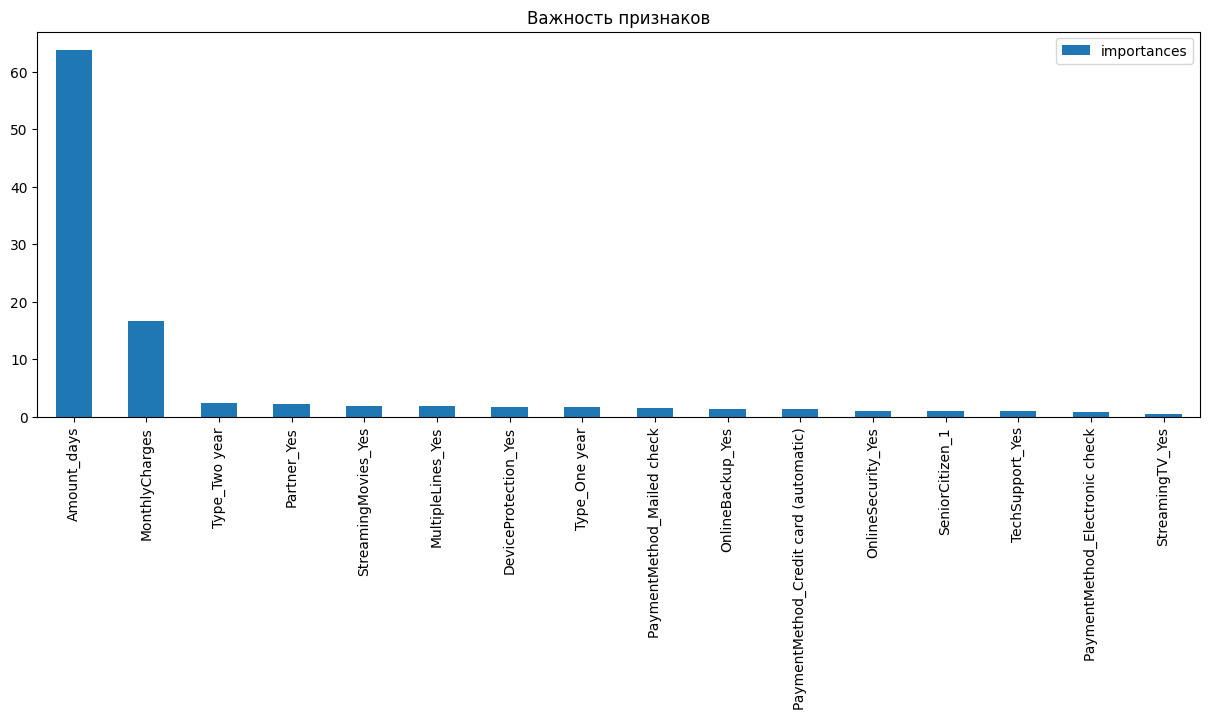

In [ ]:
importances.plot(kind='bar', figsize=(15, 5), title='Важность признаков')
plt.show();

Самый значимый признак оказался с количеством дней пользования - Amount_days, на втором месте - MonthlyCharges

### Матрица ошибок

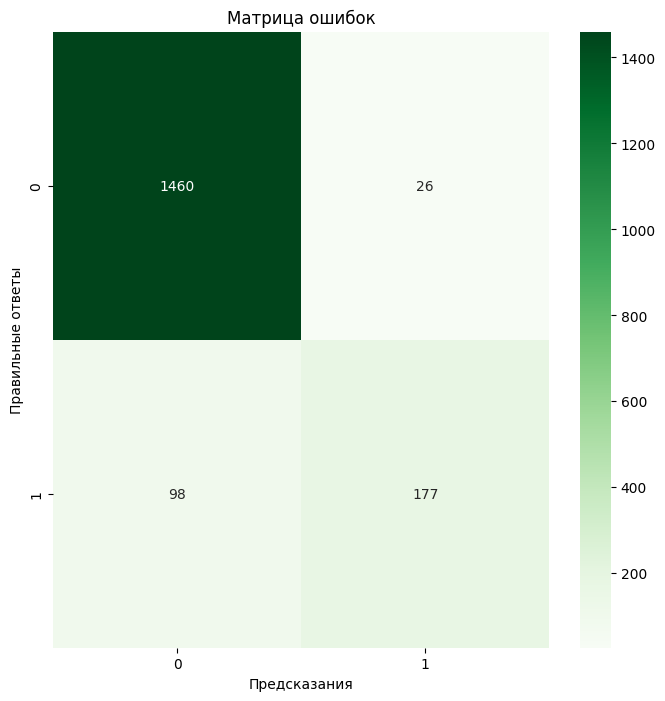

In [ ]:
predictions_test = model_cat.predict(features_ohe_test)
cmatrix = confusion_matrix(target_test, predictions_test)
plt.figure(figsize=(8, 8))
sns.heatmap(cmatrix, annot=True, cmap='Greens',
            fmt='d').set(title='Матрица ошибок', xlabel='Предсказания', ylabel='Правильные ответы')
plt.show();

Из матрицы ошибок видно, что модель достаточно часто предсказывает правильный ответ на тестовых данных.

### Выводы

1. Для построения модели датасет был поделен на тренировочную и тестовую выборки. Категориальные признаки были закодированы OneHotEncoder
- Лучшие показатели модели RandomForestClassifier ROC-AUC: 0.825 ,Accuracy: 0.832
- Лучшие показатели модели LGBMClassifier ROC-AUC: 0.879, Accuracy: 0.879
- Лучшие показатели модели CatBoostClassifier ROC-AUC: 0.923, Accuracy: 0.929
2. На тестовых данных была протестирована лучшая по показателям модель - CatBoostClassifier, ее результаты ROC-AUC: 0.919 и Accuracy: 0.929
3. Самый значимый признак лучшей модели оказался с количеством дней пользования - Amount_days, на втором месте - MonthlyCharges
4. Из матрицы ошибок видно, что модель достаточно часто предсказывает правильный ответ на тестовых данных


## Отчет

Цель работы - построить модель, которая предскажет уход клиента от оператора связи «Ниединогоразрыва.ком». Что бы вовремя предложить нелояльным клиентам скидку и этим минимизировать финансовые потери оператора.
    
Были изучены и проанализированы таблицы:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Добавлен целевой признак Target. Если клиент не ушел, то Target = 0, если ушел, то Target = 1.
Обнаруженные пропуски в столбце TotalCharges были только у новых клиентов, поэтому были заменены на значения из столбца MonthlyCharges.
Для дальнейшего обучения моделей был создан новый признак Amount_days, он показывает сколько дней клиент пользовался услугами оператора. А если клиент еще не ушел, то количество дней до выгрузки данных.
Так как не все клиенты пользовались услугами интернета/телефона, то после объединения таблиц появились пропущенные значения, они были заполнены заглушкой 'No'.
    
При анализе таблиц видно, что :
- чаще используется тип оплаты ежемесячный,
- большее количество людей предпочитают безналичный расчет,
- способ оплаты чаще электронный чек,
- мужчин и женщин примерно одинаковое количество,
- большинство из пользоватей не пенсионеры,
- немного меньше людей которые находятся в браке, чем "свободных",
- клиенты чаще не имеют иждевенцев,
- клиенты чаще выбирают оптоволокно,
- чаще не используют интернет-безопасность,
- чаще не пользуются онлайн-резервное копирование,
- чаще не используют защиту устройства,
- мало кто пользуется технической поддержкой,
- услуги потоковое тв и потоковые фильмы используют примерно одинаковое количество пользователей ,
- клиенты чаще не пользуются возможностью ведения параллельных линий во время звонка

Был рассмотрен отток клиентов по годам. Отток клиентов с конца 2017 года по конец 2019 был примерно на одном уровне, но ближе к дате выгрузки(2 февраля 2020) отток клиентов резко увеличился.
Большинство ушедших клиентов пользовались услугами оператора до 3-х лет.
Ушедшие клиенты тратили на услуги оператора больше.

Заметна сильная корреляция целевого признака с CustomerID и EndDate. Что бы не было проблем при обучении модели CustomerID был перенесен в индекс, а TotalCharges, EndDate и BeginDate удалены. Так же удалены признаки, у которых очень низкая корреляция с таргетом: 'Gender', 'Dependents', 'InternetService', 'PaperlessBilling'

Данные были разделены на тренировочную и тестовую выборки в соотношении 75:25. Для предотвращения утечки категориальные признаки были закодированы OneHotEncoder.

Для обучения были выбраны модели RandomForestClassifier, LGBMClassifier и CatBoostClassifier. Подбор параметров был через GridSearchCV, гиперпараметры лучшей модели : {'depth': 3, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.5}

Была оценена точность предсказаний моделей путем построения графика

На графике видно, что большую точность дает модель CatBoostClassifier

При обучении на тренировочной выборке лучше себя показала модель CatBoostClassifier. Она была использована на тестовых данных и показала хороший результат
    ` ROC-AUC: 0.919 и Accuracy: 0.929 `
    
Самымы значимыми признаками при обучении модели были Amount_days и MonthlyCharges

Sign          | importances
------------- | -------------
Amount_days	  | 63.768671
MonthlyCharges| 16.649937

Так же для оценки качества модели была рассмотрена матрица ошибок. Из матрицы ошибок можно сделать вывод, что с ошибкой 2 рода столкнулись 98 клиентов из тестовой выборки, еще 26 столкнулись с ошибкой 1 рода. Модель смогла правильно спрогнозировать целевой признак у остальных клиентов из тестовой выборки. Это хорошие показатели

В ходе работы над проектом все задачи были выполнены, трудностей при выполнении не было.